In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary  # Denne er fin for å printe ut informasjon om PyTorch-modeller
import matplotlib.pyplot as plt
from collections import Counter
from code_base.functions import train, custom_loss
from code_base.models import TestNet
from code_base.DataAnalysis import DataAnalysis

In [2]:
# Loading the data as PyTorch Tensor Dataset
data_train = torch.load("data/localization_train.pt")
data_val = torch.load("data/localization_val.pt")
data_test = torch.load("data/localization_test.pt")
print("Type: ", type(data_train))

Type:  <class 'torch.utils.data.dataset.TensorDataset'>


In [3]:
DataAnalysis.get_summary(data_train)

Type of images in dataset: <class 'torch.Tensor'>
First data label (a vector of P_c, box_x_pos, box_y_pos, box_height, box_width, class label):  tensor([1.0000, 0.6000, 0.2292, 0.3667, 0.4167, 4.0000])
Dataset size: 59400
Dataset shape: torch.Size([59400, 1, 48, 60])
Image shape: torch.Size([1, 48, 60])
Dataset class distribution
Class 0: 5345 examples
Class 1: 11475 examples
Class 2: 5365 examples
Class 3: 5522 examples
Class 4: 5243 examples
Class 5: 4889 examples
Class 6: 5310 examples
Class 7: 5644 examples
Class 8: 5249 examples
Class 9: 5358 examples


In [4]:
# Convert data to PyTorch Tensors
train_imgs  = torch.stack([img for img, _ in data_train])
val_imgs = torch.stack([img for img, _ in data_val])
test_imgs = torch.stack([img for img, _ in data_test])
y_train = [label for _, label in data_train]
y_val = [label for _, label in data_val]
y_test = [label for _, label in data_test]

# Display some useful information about the data
print("Type of images in training set: ", type(train_imgs[0]))
print("First training label (a vector of P_c, box_x_pos, box_y_pos, box_height, box_width, class label): ", y_train[0])
print(f"Training dataset size: {len(train_imgs)}")
print(f"Validation dataset size: {len(val_imgs)}")
print(f"Test dataset size: {len(test_imgs)}")
print(f"Training dataset shape: {train_imgs.shape}")
print(f"Image shape: {train_imgs[0].shape}")

# Counts number of samples belonging to each class in training set
class_counts = {}
for label_vector in y_train:
    label = int(label_vector[-1])
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

print("Training dataset class distribution:")
for label, count in sorted(class_counts.items()):
    print(f"Class {label}: {count} examples")

Type of images in training set:  <class 'torch.Tensor'>
First training label (a vector of P_c, box_x_pos, box_y_pos, box_height, box_width, class label):  tensor([1.0000, 0.6000, 0.2292, 0.3667, 0.4167, 4.0000])
Training dataset size: 59400
Validation dataset size: 6600
Test dataset size: 11000
Training dataset shape: torch.Size([59400, 1, 48, 60])
Image shape: torch.Size([1, 48, 60])
Training dataset class distribution:
Class 0: 5345 examples
Class 1: 11475 examples
Class 2: 5365 examples
Class 3: 5522 examples
Class 4: 5243 examples
Class 5: 4889 examples
Class 6: 5310 examples
Class 7: 5644 examples
Class 8: 5249 examples
Class 9: 5358 examples


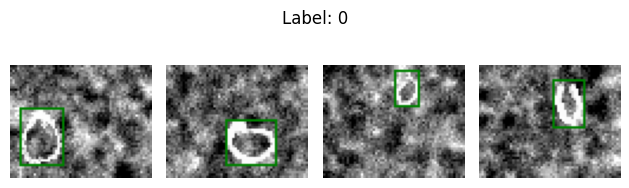

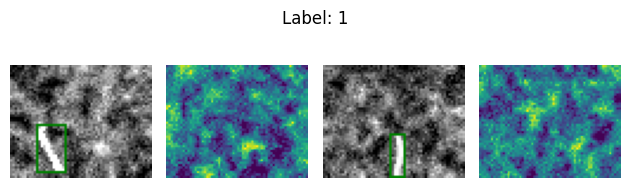

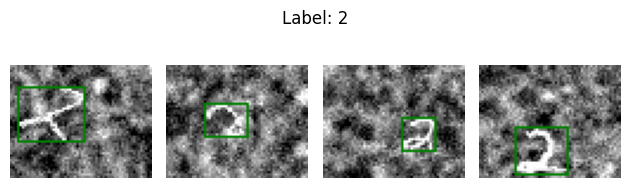

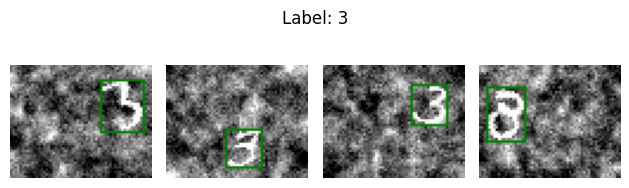

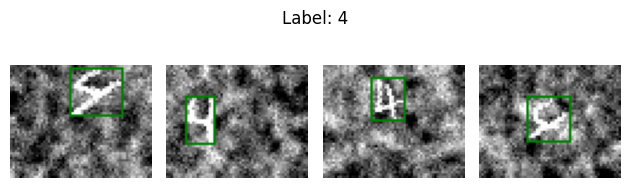

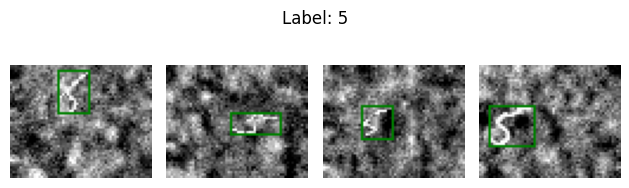

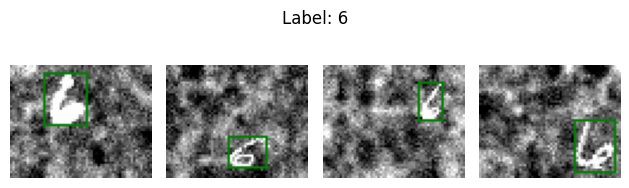

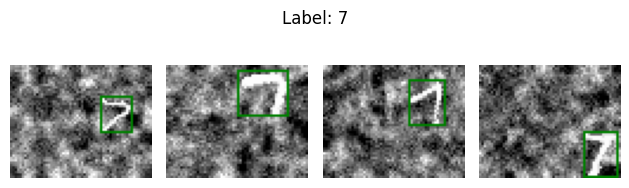

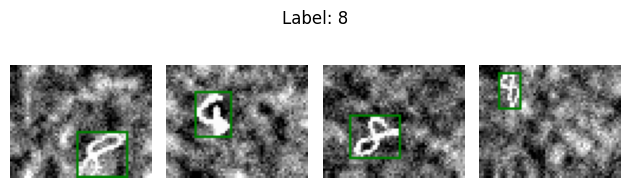

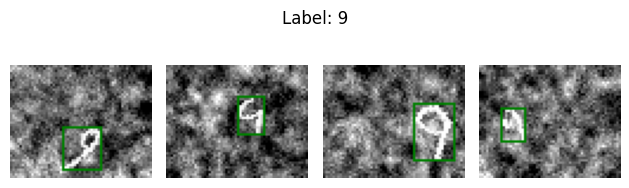

In [5]:
# Display 4 instances of each class
n_classes = len(Counter([int(label[-1]) for _, label in data_train]))
for i in range(n_classes):
    DataAnalysis.plot_instances_with_bounding_box(data_train, i, n_instances=4)

In [6]:
batch_size = 512
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=False)

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Temporary code for testing train function
model = TestNet()
model.to(device)

learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
train_loss, val_loss = train(30, optimizer, model, custom_loss, train_loader, val_loader, device)

21:26:27.986281, 1, train_loss: 5.465318632940961, val_loss: 3.768351041353666


KeyboardInterrupt: 

In [ ]:
DataAnalysis.plot_performance_over_time(train_loss, val_loss, "Training vs val loss")